In [ ]:
from google.colab import drive
from pathlib import Path
drive.mount('/content/gdrive', force_remount=False)
check = Path.cwd()/'gdrive/MyDrive/TMProject'
files = list(check.glob("**/*.npy"))


Mounted at /content/gdrive


In [ ]:
!pip install datasets

     |████████████████████████████████| 306 kB 7.5 MB/s 
     |████████████████████████████████| 67 kB 5.2 MB/s 
     |████████████████████████████████| 133 kB 60.9 MB/s 
     |████████████████████████████████| 243 kB 58.0 MB/s 
     |████████████████████████████████| 1.1 MB 64.6 MB/s 
     |████████████████████████████████| 160 kB 73.5 MB/s 
     |████████████████████████████████| 192 kB 68.3 MB/s 
     |████████████████████████████████| 271 kB 79.8 MB/s 


In [ ]:
# Data Manipultion
import numpy as np
import pandas as pd
# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az
from IPython.display import Audio, display
from tqdm import tqdm

# OS
from pathlib import Path
import glob
from joblib import dump, load

# ML
# from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
# from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import precision_score, recall_score, f1_score, precision_recall_fscore_support, multilabel_confusion_matrix
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import MultiLabelBinarizer

# Bayesian
from pymc3.stats import hdi
# DL

# NLP
from datasets import load_dataset, list_datasets

## Helper Functions

In [ ]:
def get_data(*args, **kwargs):
    """Function to load Reuters data using HuggingFace API."""
    reuters = load_dataset("reuters21578","ModApte") # ModApte b'coz of "A re-examination of text categorization methods" paper
    train = reuters['train'] # Same as paper
    test = reuters['test'] # Same as paper
    train.set_format(type = "pandas")
    test.set_format(type = "pandas")   
    df_train = train[:]
    df_test = test[:]
    # Get empty Indexes: required for dealing with Tensored datasets
    empty_train = df_train.index[df_train.topics.str.len().eq(0)] 
    empty_test = df_test.index[df_test.topics.str.len().eq(0)]

    df_train = df_train[~df_train.topics.str.len().eq(0)] # Drop Empty Topics
    df_test = df_test[~df_test.topics.str.len().eq(0)] # Drop Empty Topics
    cols =df_train.columns

    df_train = df_train.drop([col for col in cols if col not in ['text', 'topics']], axis=1)
    df_test = df_test.drop([col for col in cols if col not in ['text', 'topics']], axis=1)

    X_train = df_train['text']
    X_test = df_test['text']
    mlb = MultiLabelBinarizer()
    y_train = mlb.fit_transform(df_train.topics)
    y_test = mlb.transform(df_test.topics)
    print("Use different yTest and yTrain for BERT model")
    return X_train,X_test,y_train,y_test, empty_train,empty_test, mlb

def get_from_colab(check,name):
    return np.load(f"{check}/{name}.npy")

def spacy_tokenizer(text):
    """SpaCy Tokenizer pipeline"""
    doc = nlp(text, disable=['ner', 'tagger', 'parser'])
    return [token.text for token in doc if not token.is_stop and not token.is_punct]

def allDone():
  display(Audio(url='https://sound.peal.io/ps/audios/000/000/537/original/woo_vu_luvub_dub_dub.wav', autoplay=True))


######
def model_eval(actual,predicted,score,*args,**kwargs):
    model_score = score(actual,predicted,*args,**kwargs)
    return model_score
def hypothesis_test(dx_i,dx, significance=0.05, hypothesis=""):
    """
    Implementation of paired-bootstrap test.
    Reference: Berg-Kirkpatrick, et. al. "An empirical investigation of statistical significance in nlp."
    """
    p_value = np.mean(dx_i>= (2*dx))
    diff = np.quantile(dx_i, q=(0.025,0.975))
    
    print("\n")
    if p_value<significance:
        
        print(f"We reject the null hypothesis for {hypothesis} at a significance of {significance} at p-value: {p_value}")

    else:
        print(f"We fail to reject the Null Hypothesis {hypothesis} at a significance of {significance} at p-value: {p_value}")
    print(f"95% CI of delta: {diff}")
    print("#"*10)

def paired_bootstrap_test(test_set, model1,model2, B, *args,**kwargs):
    """
    Function to generate \delta(x) and \delta(x^{(i)}) for B bootstrap samples.
    Reference: 
        Jurafsky, Daniel, and James H. Martin. "Speech and Language Processing: An Introduction to Natural Language Processing, Computational Linguistics, and Speech Recognition."
    Params:
    ------
    test_set: np.ndarray, Array of test outputs.
    model1: np.ndarray, Array of Model A's output.
    model2: np.ndarray, Array of Model B's output.
    B : int, No of Bootstrap's to be generated
    score: Evaluation algorithm.
    """
    N = test_set.shape[0]
    p1,r1,f1_1,_=  precision_recall_fscore_support(test_set, model1, *args,**kwargs)
    p2,r2,f1_2,_ =  precision_recall_fscore_support(test_set, model2, *args,**kwargs)
    delta_precision =  p1-p2 #\delta(x)
    delta_recall = r1-r2
    delta_f1 = f1_1-f1_2
    deltas_p = np.zeros(B) # for storing \delta(X) of bootstraps
    deltas_r =  np.zeros(B)
    deltas_f1 =  np.zeros(B)
    indexes = np.random.randint(low=0, high=N, size=(B,N))
    for boot in tqdm(range(B)):
        
        sampleY = test_set[indexes[boot,:],:]
        sample1 = model1[indexes[boot,:],:]
        model1_p, model1_r,model1_f1,_ = precision_recall_fscore_support(sampleY, sample1,*args,**kwargs)
        sample2 = model2[indexes[boot,:],:]
        model2_p,model2_r,model2_f1,_ = precision_recall_fscore_support(sampleY, sample2, *args, **kwargs)
        # delta_b = sc1 - sc2
        delta_p_boot = model1_p-model2_p
        delta_r_boot = model1_r - model2_r
        delta_f1_boot = model1_f1 - model2_f1

        deltas_p[boot] = delta_p_boot
        deltas_r[boot] = delta_r_boot
        deltas_f1[boot] = delta_f1_boot

    for hype in ['precision', 'recall', 'f1']:
        if hype =="precision":
            hypothesis_test(deltas_p,delta_precision, significance=0.05, hypothesis=hype)
        if hype=='recall':
            hypothesis_test(deltas_r,delta_recall, significance=0.05, hypothesis=hype)
        if hype == "f1":
            hypothesis_test(deltas_f1,delta_f1, significance=0.05, hypothesis=hype)
    # return (deltas, delta)


    # return p_value
    

### Data Loading

In [ ]:
# class_0 = np.where(svm[:,0]) # will give all the arrays where col 0 is 1.

In [ ]:
# np.intersect1d(np.where(ytest[:,0]),np.where(knn[:,0]))
# np.where([any(np.where(ytrain[:,i])[0]) for i in range(M)])

In [ ]:
# mlb.classes_

len(ytrain)

7775

In [ ]:
# save data

_,_,ytrain,ytest, _,_, mlb = get_data()

## For BERT
ytrain_bert_idx  = get_from_colab(check, 'tuned_bert_original_train_idx')
ytest_bert_idx = get_from_colab(check, 'tuned_bert_original_test_idx')
## train 
ytrain_dummy = np.load(f"{check}/ytrain_dummy.npy")
ytrain_nb = np.load(f"{check}/naive_bayes_train.npy")
ytrain_knn = np.load(f"{check}/knn_train.npy")
ytrain_svm = np.load(f"{check}/svm_train.npy")
ytrain_nn = get_from_colab(check,'nn_train')
ytrain_dt = get_from_colab(check, 'ytrain_dt')
ytrain_rf = get_from_colab(check, 'ytrain_rf')
ytrain_adab = get_from_colab(check, 'ytrain_adab')
ytrain_bert = get_from_colab(check, 'tuned_bert_output_train')


## test
ytestdummy = np.load(f"{check}/ytest_dummy.npy")

ytest_nb = np.load(f"{check}/naive_bayes.npy")

ytest_knn = np.load(f"{check}/knn.npy")

ytest_svm = np.load(f"{check}/svm.npy")

ytest_nn = get_from_colab(check,'nn')

ytest_dt = get_from_colab(check, 'ytest_dt')

ytest_rf = get_from_colab(check, 'ytest_rf')

ytest_adab = get_from_colab(check, 'ytest_adab')

ytest_pred_bert = get_from_colab(check, 'tuned_bert_output_test')
# test outputs
model_test_result = (ytestdummy,ytest_nb,ytest_knn, ytest_svm, ytest_nn, ytest_dt, ytest_rf, ytest_adab)
# print(ytest_pred_bert.shape)


Downloading:   0%|          | 0.00/4.17k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.37k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/8.15M [00:00<?, ?B/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Dataset reuters21578 downloaded and prepared to /root/.cache/huggingface/datasets/reuters21578/ModApte/1.0.0/98a2ad6a0242627562db83992f9625261854c40a88619322596153a5a16a206c. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:876: UserWarning: unknown class(es) ['cottonseed', 'f-cattle', 'sfr'] will be ignored
  "unknown class(es) {0} will be ignored".format(sorted(unknown, key=str))


Use different yTest and yTrain for BERT model


### Bayesian Sampling

In [ ]:
def get_prior_pi(data, y1, y2):

    # Probabilities of \pi_1, \pi_2, \pi_3
    # \pi_1[i] = N1/N[i] 
    # Training or Validation data should be used here.
    N = len(data)
    N1 = np.sum( np.logical_and(data[:,:]==y1[:,:],data[:,:]!=y2[:,:] ),axis=0) # A better than B
    N2 = np.sum( np.logical_and(data[:,:]!=y1[:,:],data[:,:]==y2[:,:] ),axis=0) # B better than A
    both_bad = np.sum( np.logical_and(data[:,:]!=y1[:,:],data[:,:]!=y2[:,:] ),axis=0) # Both are wrong
    both_gud = np.sum( np.logical_and(data[:,:]==y1[:,:],data[:,:]==y2[:,:] ),axis=0) # Both are right
    N3 = both_bad + both_gud
    # return (N1/N,N2/N,N3/N)
    return N1,N2,N3

In [ ]:
# pi1,pi2,pi3 = get_prior_pi(data=ytrain, y1=ytrain_knn,y2=ytrain_svm)

In [ ]:
# N1 = np.sum(np.logical_and(ytest[:, :] == svm[:,:], ytest[:, :] != nn[:,:]), axis=0) # A better than B
# N2= (np.sum(np.logical_and(ytest[:, :] != svm[:,:], ytest[:, :] == nn[:,:]), axis=0)) # B better than A
# a3 = (np.sum(np.logical_and(ytest[:, :] != svm[:,:], ytest[:, :] != nn[:,:]), axis=0)) # Both suck!
# a4 = (np.sum(np.logical_and(ytest[:, :] == svm[:,:], ytest[:, :] == nn[:,:]), axis=0)) # Both correct
# N3 = a3+a4

In [ ]:
# from numpy.ma.core import shape
def get_post_dist( test_data, model_1_data, model_2_data, measure, samples):
    """
    Generates the Posterior distribution of the evaluation metric.
    """
    N = len(test_data) # No of datapoints
    # print(N)
    M = test_data.shape[-1] # No of labels
    # print(M)
    # wrt model1
    MCM1 = multilabel_confusion_matrix(test_data, model_1_data)
    tns1, fns1, tps1, fps1 = MCM1[:,0,0], MCM1[:,1,0], MCM1[:,1,1],MCM1[:,0,1]
    # wrt model 2
    MCM2 = multilabel_confusion_matrix(test_data, model_2_data)
    tns2, fns2, tps2, fps2 = MCM2[:,0,0], MCM2[:,1,0], MCM2[:,1,1],MCM2[:,0,1]

    l = 0.5 # Lambda's value for Jeffrey's prior.
    matrix1 = np.zeros((M,samples))
    matrix2 = np.zeros((M,samples))
    if measure=="precision":
        for i in range(M):
            model1 = np.random.beta(a = tps1[i]+l, b=fps1[i]+l, size=samples)
            matrix1[i,:] = model1
            model2 = np.random.beta(a = tps2[i]+l, b=fps2[i]+l, size=samples)
            matrix2[i,:] = model2
    if measure == 'recall':
        for i in range(M):
            model1 = np.random.beta(a = tps1[i]+l, b=fns1[i]+l, size=samples)
            matrix1[i,:] = model1
            model2 = np.random.beta(a = tps2[i]+l, b=fns2[i]+l, size=samples)
            matrix2[i,:] = model2
    if measure == 'f1':
        h = 1 # Chosen shape parameter for \Gamma distribution
        for i in range(M):
            U1 = np.random.gamma(shape = 2*h, scale=tps1[i]+l, size =samples)
            V1 = np.random.gamma(shape = h, scale = fps1[i]+fns1[i]+(2*l), size = samples)
            F1 = U1/(U1+V1)
            matrix1[i,:] = F1
            U2 = np.random.gamma(shape = 2*h, scale=tps2[i]+l, size =samples)
            V2 = np.random.gamma(shape = h, scale = fps2[i]+fns2[i]+(2*l), size = samples)
            F2 = U2/(U2+V2)
            matrix2[i,:] = F2
            
    return matrix1, matrix2

def get_post_prob(m1,m2):
    """Function to get posterior probability of the Hypothesis"""

    delta = m1-m2
    average_delta = np.mean(delta, axis=0)
    rope = 0.005
    p_less = np.mean(average_delta<-rope)  ## Pr(systemA<systemB | Data)
    p_equal = np.mean(np.logical_and(average_delta>=-rope, average_delta<=rope)) # Pr(systemA=systemB | Data)
    p_more = np.mean(average_delta>rope) ## Pr(systemA>systemB | Data)
    probs = np.array([p_less,p_equal,p_more])
    probs = probs/np.sum(probs)
    decision = ['less', 'equal', 'more']
    print(f"Decision: {decision[np.argmax(probs)]}")
    # return average_delta
    return probs, average_delta

def get_hdi(arr, alpha):
    """Returns Credible Interval for the Posterior Distribution"""
    return hdi(ary=arr, hdi_prob=alpha)
def plot_diff(dx, title, xlabel):
    az.style.use("arviz-darkgrid")
    # ax = sns.kdeplot(dx)
    # az.plot_kde(dx, quantiles=[0.025,0.975], rug=True)
    az.plot_posterior(dx, hdi_prob=0.95, rope=[-0.05,0.05], rope_color='red', point_estimate='mean')
    # plt.xlim(0,1)
    plt.title(f"{title}")
    plt.ylabel("pdf")
    plt.xlabel(r"$\delta$" +f" {xlabel}")

    # plt.axvline(x=-0.01,linestyle='dashed', color='red', label=r"rope", linewidth=1)
    # plt.axvline(x=+0.01, linestyle='dashed', color='red',  linewidth=1)
    plt.legend()
    plt.show()

### miP

#### Test

In [ ]:
m1,m2 = get_post_dist(ytest[ytest_bert_idx,:], ytest_nb[ytest_bert_idx,:], ytest_pred_bert ,'precision', 10_000)

In [ ]:
pr, dx = get_post_prob(m1,m2)

Decision: less


In [ ]:
print([np.round(p,decimals=2) for p in pr])

print(get_hdi(dx,0.95))

[0.78, 0.06, 0.16]
[-0.12637648  0.0456016 ]


No handles with labels found to put in legend.


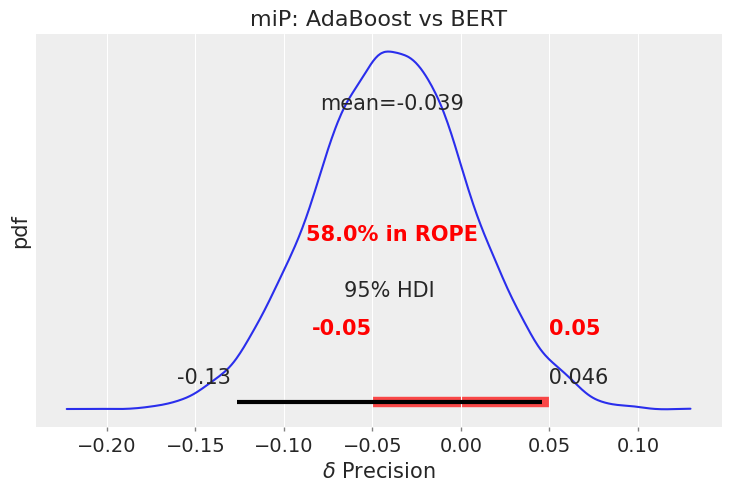

In [ ]:
plot_diff(dx, title='AdaBoost vs BERT', xlabel="Precision") 

## miR

In [ ]:
m1,m2 = get_post_dist(ytest, ytest_nb, ytest_knn ,'recall', 10_000)

In [ ]:
pr, dx = get_post_prob(m1,m2)

Decision: equal


In [ ]:
print([np.round(p,decimals=2) for p in pr])

print(get_hdi(dx,0.95))

[0.0142, 0.6946, 0.4619]
[-0.04409955  0.05850898]


No handles with labels found to put in legend.


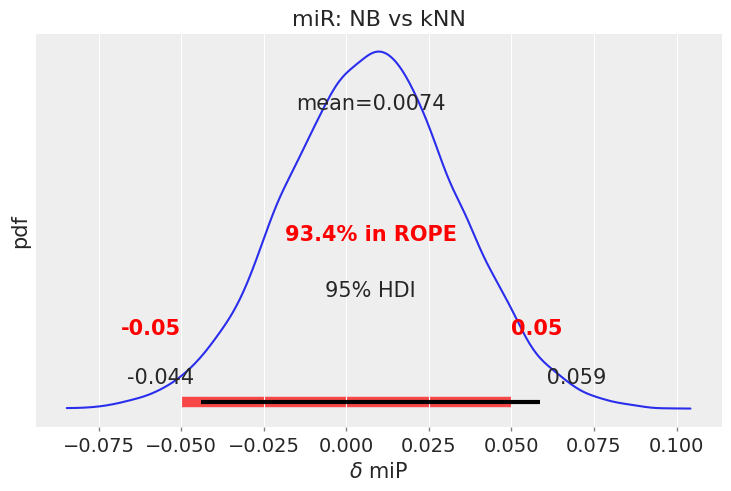

In [ ]:
plot_diff(dx, title='miR: NB vs kNN')

## miF

In [ ]:
# m1,m2 = get_post_dist(ytest[ytest_bert_idx,:], ytest_svm[ytest_bert_idx,:], ytest_pred_bert ,'f1', 10_000)

m1,m2 = get_post_dist(ytest, ytest_knn, ytest_nn,'f1', 10_000)

In [ ]:
pr, dx = get_post_prob(m1,m2)

Decision: less


In [ ]:
print([np.round(p,decimals=2) for p in pr])

print(get_hdi(dx,0.95))

[1.0, 0.0, 0.0]
[-0.20883718 -0.09174845]


## Plotting

No handles with labels found to put in legend.


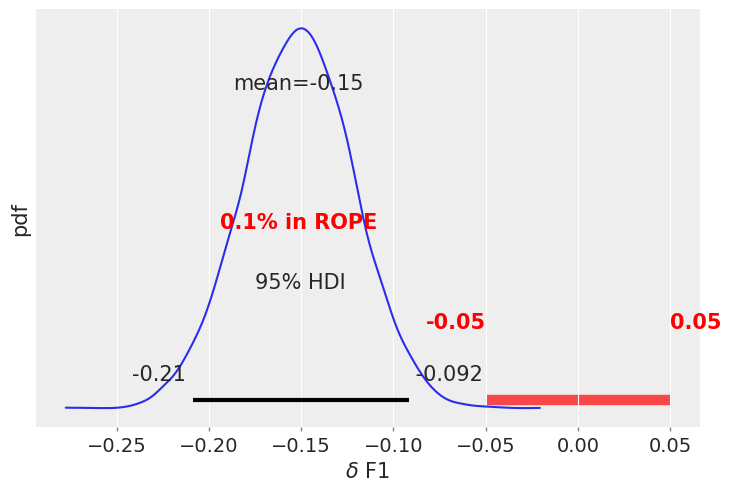

In [ ]:
plot_diff(dx, title='', xlabel="F1")